***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4195)


In [6]:
df['url_port']=df['url_port'].apply(lambda x: 0 if x==0 else 1 )

df['url_number_vowels/url_length'] = (df['domain'].str.lower().str.count(r'[aeiou]'))/(df['domain'].apply(lambda x: len(str(x))))

df['url_number_consonants/url_length'] = (df['domain'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I))/(df['domain'].apply(lambda x: len(str(x))))

df['url_number_digits/url_length'] = (df['domain'].str.count(r'\d'))/(df['domain'].apply(lambda x: len(str(x))))

df['url_number_special_chars/url_length']=1.0-df[['url_number_vowels/url_length','url_number_consonants/url_length','url_number_digits/url_length']].sum(axis=1)

In [9]:
df.set_index(['domain'],inplace=True,drop=True)

In [10]:
fin_col=['url_char_%',
 'url_char_&',
 'url_char_+',
 'url_char_-',
 'url_char_.',
 'url_char_/',
 'url_char_:',
 'url_char_=',
 'url_char_?',
 'url_char__',
 'url_port',
 'url_number_vowels/url_length',
 'url_number_consonants/url_length',
 'url_number_digits/url_length',
 'url_number_special_chars/url_length',
 'Target']

In [11]:
df_sel=df[fin_col]

In [12]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [13]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [14]:
columns=fin_col

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [15]:
columns.remove('Target')

In [16]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [17]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.93796937221
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31163   729    31892
True        1592  3933     5525
__all__    32755  4662    37417

Accuracy of the model for test data is: 0.930617917468
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7774   211     7985
True         438   931     1369
__all__     8212  1142     9354



Logistic Regression
Accuracy of the model for training data is: 0.935724403346
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31228   664    31892
True        1741  3784     5525
__all__    32969  4448    37417

Accuracy of the model for test data is: 0.932007697242
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7810   175     7985
True         461   908     1369
__all__     8271  1083     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.946949247668
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31196   696    31892
True        1289  4236     5525
__all__    32485  4932    37417

Accuracy of the model for test data is: 0.939384220654
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7774   211     7985
True         356  1013     1369
__all__     8130  1224     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.936820161958
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31291   601    31892
True        1763  3762     5525
__all__    33054  4363    37417

Accuracy of the model for test data is: 0.937353004062
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7832   153     7985
True         433   936     1369
__all__     8265  1089     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.942272229201
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31106   786    31892
True        1374  4151     5525
__all__    32480  4937    37417

Accuracy of the model for test data is: 0.939491126791
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7778   207     7985
True         359  1010     1369
__all__     8137  1217     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.947430312425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31200   692    31892
True        1275  4250     5525
__all__    32475  4942    37417

Accuracy of the model for test data is: 0.939384220654
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7770   215     7985
True         352  1017     1369
__all__     8122  1232     9354



Bagging Classifier
Accuracy of the model for training data is: 0.947082876767
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31181   711    31892
True        1269  4256     5525
__all__    32450  4967    37417

Accuracy of the model for test data is: 0.939063502245
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7766   219     7985
True         351  1018     1369
__all__     8117  1237     9354



Neural Network-1
The accuracy of the model on training data is: 0.94286019724


Predicted  False  True  __all__
Actual                         
False      31113   779    31892
True        1359  4166     5525
__all__    32472  4945    37417

The accuracy of the model on test data is: 0.938742783836


Predicted  False  True  __all__
Actual                         
False       7772   213     7985
True         360  1009     1369
__all__     8132  1222     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [18]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [19]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.937969,3933.0,31163.0,729.0,1592.0,0.022858,0.288145
LogisticRegression,0.935724,3784.0,31228.0,664.0,1741.0,0.020820,0.315113
RandomForestClassifier,0.946949,4236.0,31196.0,696.0,1289.0,0.021824,0.233303
AdaBoostClassifier,0.936820,3762.0,31291.0,601.0,1763.0,0.018845,0.319095
GradientBoostingClassifier,0.942272,4151.0,31106.0,786.0,1374.0,0.024646,0.248688
ExtraTreeClassifier,0.947430,4250.0,31200.0,692.0,1275.0,0.021698,0.230769
BaggingClassifier,0.947083,4256.0,31181.0,711.0,1269.0,0.022294,0.229683
Neural Network-1,0.942860,4166.0,31113.0,779.0,1359.0,0.024426,0.245973


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.930618,931.0,7774.0,211.0,438.0,0.026425,0.319942,0.826817,0.705694
LogisticRegression,0.932008,908.0,7810.0,175.0,461.0,0.021916,0.336742,0.820671,0.708493
RandomForestClassifier,0.939384,1013.0,7774.0,211.0,356.0,0.026425,0.260044,0.856766,0.747853
AdaBoostClassifier,0.937353,936.0,7832.0,153.0,433.0,0.019161,0.316289,0.832275,0.732371
GradientBoostingClassifier,0.939491,1010.0,7778.0,207.0,359.0,0.025924,0.262235,0.855921,0.747902
ExtraTreeClassifier,0.939384,1017.0,7770.0,215.0,352.0,0.026925,0.257122,0.857976,0.748319
BaggingClassifier,0.939064,1018.0,7766.0,219.0,351.0,0.027426,0.256392,0.858091,0.747274
Neural Network-1,0.938743,1009.0,7772.0,213.0,360.0,0.026675,0.262966,0.858091,0.745046


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [20]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [21]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [22]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [23]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.862065721811
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30915    977    31892
True        7821  24071    31892
__all__    38736  25048    63784

Accuracy of the model for test data is: 0.926876202694
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7695   290     7985
True         394   975     1369
__all__     8089  1265     9354



Logistic Regression
Accuracy of the model for training data is: 0.876567791296
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29447   2445    31892
True        5428  26464    31892
__all__    34875  28909    63784

Accuracy of the model for test data is: 0.908060722685
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7347   638     7985
True         222  1147     1369
__all__     7569  1785     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.910808353192
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30258   1634    31892
True        4055  27837    31892
__all__    34313  29471    63784

Accuracy of the model for test data is: 0.922599957238
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7505   480     7985
True         244  1125     1369
__all__     7749  1605     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.88704063715
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29511   2381    31892
True        4824  27068    31892
__all__    34335  29449    63784

Accuracy of the model for test data is: 0.90880906564
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7334   651     7985
True         202  1167     1369
__all__     7536  1818     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.893076633639
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29994   1898    31892
True        4922  26970    31892
__all__    34916  28868    63784

Accuracy of the model for test data is: 0.922172332692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7464   521     7985
True         207  1162     1369
__all__     7671  1683     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.91116894519
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30287   1605    31892
True        4061  27831    31892
__all__    34348  29436    63784

Accuracy of the model for test data is: 0.923027581783
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7518   467     7985
True         253  1116     1369
__all__     7771  1583     9354



Bagging Classifier
Accuracy of the model for training data is: 0.910824031105
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30204   1688    31892
True        4000  27892    31892
__all__    34204  29580    63784

Accuracy of the model for test data is: 0.920568740646
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7487   498     7985
True         245  1124     1369
__all__     7732  1622     9354



Neural Network-1
The accuracy of the model on training data is: 0.894628747021


Predicted  False   True  __all__
Actual                          
False      30022   1870    31892
True        4851  27041    31892
__all__    34873  28911    63784

The accuracy of the model on test data is: 0.921103271328


Predicted  False  True  __all__
Actual                         
False       7468   517     7985
True         221  1148     1369
__all__     7689  1665     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [24]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [25]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.862066,24071.0,30915.0,977.0,7821.0,0.030635,0.245234
LogisticRegression,0.876568,26464.0,29447.0,2445.0,5428.0,0.076665,0.170199
RandomForestClassifier,0.910808,27837.0,30258.0,1634.0,4055.0,0.051235,0.127148
AdaBoostClassifier,0.887041,27068.0,29511.0,2381.0,4824.0,0.074658,0.151261
GradientBoostingClassifier,0.893077,26970.0,29994.0,1898.0,4922.0,0.059513,0.154333
ExtraTreeClassifier,0.911169,27831.0,30287.0,1605.0,4061.0,0.050326,0.127336
BaggingClassifier,0.910824,27892.0,30204.0,1688.0,4000.0,0.052929,0.125423
Neural Network-1,0.894629,27041.0,30022.0,1870.0,4851.0,0.058635,0.152107


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.926876,975.0,7695.0,290.0,394.0,0.036318,0.287801,0.837940,0.698581
LogisticRegression,0.908061,1147.0,7347.0,638.0,222.0,0.079900,0.162162,0.878969,0.681765
RandomForestClassifier,0.922600,1125.0,7505.0,480.0,244.0,0.060113,0.178232,0.880828,0.714064
AdaBoostClassifier,0.908809,1167.0,7334.0,651.0,202.0,0.081528,0.147553,0.885460,0.688622
GradientBoostingClassifier,0.922172,1162.0,7464.0,521.0,207.0,0.065247,0.151205,0.891774,0.721002
ExtraTreeClassifier,0.923028,1116.0,7518.0,467.0,253.0,0.058485,0.184806,0.878354,0.713328
BaggingClassifier,0.920569,1124.0,7487.0,498.0,245.0,0.062367,0.178963,0.879335,0.708306
Neural Network-1,0.921103,1148.0,7468.0,517.0,221.0,0.064746,0.161432,0.879335,0.715053


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [26]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [27]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 15)


In [28]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [29]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.828325791855
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5388   137     5525
True        1760  3765     5525
__all__     7148  3902    11050

Accuracy of the model for test data is: 0.925165704511
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7702   283     7985
True         417   952     1369
__all__     8119  1235     9354



Logistic Regression
Accuracy of the model for training data is: 0.877104072398
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5090   435     5525
True         923  4602     5525
__all__     6013  5037    11050

Accuracy of the model for test data is: 0.908274534958
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7349   636     7985
True         222  1147     1369
__all__     7571  1783     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.89963800905
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5225   300     5525
True         809  4716     5525
__all__     6034  5016    11050

Accuracy of the model for test data is: 0.91030575155
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7372   613     7985
True         226  1143     1369
__all__     7598  1756     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.882443438914
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5004   521     5525
True         778  4747     5525
__all__     5782  5268    11050

Accuracy of the model for test data is: 0.898225358136
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7225   760     7985
True         192  1177     1369
__all__     7417  1937     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.889230769231
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5142   383     5525
True         841  4684     5525
__all__     5983  5067    11050

Accuracy of the model for test data is: 0.914688903143
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7390   595     7985
True         203  1166     1369
__all__     7593  1761     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.90036199095
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5262   263     5525
True         838  4687     5525
__all__     6100  4950    11050

Accuracy of the model for test data is: 0.912443874278
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7396   589     7985
True         230  1139     1369
__all__     7626  1728     9354



Bagging Classifier
Accuracy of the model for training data is: 0.899547511312
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5234   291     5525
True         819  4706     5525
__all__     6053  4997    11050

Accuracy of the model for test data is: 0.910947188369
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7379   606     7985
True         227  1142     1369
__all__     7606  1748     9354



Neural Network-1
The accuracy of the model on training data is: 0.890135746596


Predicted  False  True  __all__
Actual                         
False       5136   389     5525
True         825  4700     5525
__all__     5961  5089    11050

The accuracy of the model on test data is: 0.91597177678


Predicted  False  True  __all__
Actual                         
False       7400   585     7985
True         201  1168     1369
__all__     7601  1753     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [30]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [31]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.828326,3765.0,5388.0,137.0,1760.0,0.024796,0.318552
LogisticRegression,0.877104,4602.0,5090.0,435.0,923.0,0.078733,0.167059
RandomForestClassifier,0.899638,4716.0,5225.0,300.0,809.0,0.054299,0.146425
AdaBoostClassifier,0.882443,4747.0,5004.0,521.0,778.0,0.094299,0.140814
GradientBoostingClassifier,0.889231,4684.0,5142.0,383.0,841.0,0.069321,0.152217
ExtraTreeClassifier,0.900362,4687.0,5262.0,263.0,838.0,0.047602,0.151674
BaggingClassifier,0.899548,4706.0,5234.0,291.0,819.0,0.052670,0.148235
Neural Network-1,0.890136,4700.0,5136.0,389.0,825.0,0.070407,0.149321


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.925166,952.0,7702.0,283.0,417.0,0.035441,0.304602,0.829978,0.689080
LogisticRegression,0.908275,1147.0,7349.0,636.0,222.0,0.079649,0.162162,0.879094,0.682282
RandomForestClassifier,0.910306,1143.0,7372.0,613.0,226.0,0.076769,0.165084,0.879074,0.686247
AdaBoostClassifier,0.898225,1177.0,7225.0,760.0,192.0,0.095178,0.140248,0.882287,0.666929
GradientBoostingClassifier,0.914689,1166.0,7390.0,595.0,203.0,0.074515,0.148283,0.888601,0.702727
ExtraTreeClassifier,0.912444,1139.0,7396.0,589.0,230.0,0.073763,0.168006,0.879115,0.690590
BaggingClassifier,0.910947,1142.0,7379.0,606.0,227.0,0.075892,0.165814,0.879147,0.687587
Neural Network-1,0.915972,1168.0,7400.0,585.0,201.0,0.073262,0.146822,0.879147,0.706415


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [32]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [33]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [34]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 435 features
EntitySet scattered to workers in 4.889 seconds
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [35]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [36]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [37]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [38]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [39]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [40]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [41]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [48]:
X=fs[feature_selection_df[feature_selection_df.Total>=4]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 55)

In [49]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_number_vowels/url_length / url_char_/',
 'url_number_vowels/url_length / url_char_.',
 'url_number_special_chars/url_length / url_char_/',
 'url_number_digits/url_length / url_number_special_chars/url_length',
 'url_number_digits/url_length / url_number_consonants/url_length',
 'url_number_digits/url_length / url_char_/',
 'url_number_digits/url_length / url_char_.',
 'url_number_digits/url_length + url_number_special_chars/url_length',
 'url_number_digits/url_length * url_number_vowels/url_length',
 'url_number_digits/url_length * url_number_special_chars/url_length',
 'url_number_consonants/url_length / url_char_/',
 'url_number_consonants/url_length / url_char_.',
 'url_number_consonants/url_length * url_number_digits/url_length',
 'url_char_/ / url_number_consonants/url_length',
 'url_char_/ / url_char_.',
 'url_char_/ + url_port',
 'url_char_/ + url_number_special_chars/url_length',
 'url_char_/ + url_number_digits/url_length',
 'url_char_/ + url_char__',
 'url_char_/ + url_

In [50]:
fs=fs.reindex(df_sel.index.values)

In [51]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [52]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [53]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.939065130823
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31243   649    31892
True        1631  3894     5525
__all__    32874  4543    37417

Accuracy of the model for test data is: 0.935001069061
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7804   181     7985
True         427   942     1369
__all__     8231  1123     9354



Logistic Regression
Accuracy of the model for training data is: 0.939118582463
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31178   714    31892
True        1564  3961     5525
__all__    32742  4675    37417

Accuracy of the model for test data is: 0.93564250588
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7786   199     7985
True         403   966     1369
__all__     8189  1165     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.947109602587
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31160   732    31892
True        1247  4278     5525
__all__    32407  5010    37417

Accuracy of the model for test data is: 0.939063502245
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7759   226     7985
True         344  1025     1369
__all__     8103  1251     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.939840179598
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31206   686    31892
True        1565  3960     5525
__all__    32771  4646    37417

Accuracy of the model for test data is: 0.937032285653
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7806   179     7985
True         410   959     1369
__all__     8216  1138     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.943127455435
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31085   807    31892
True        1321  4204     5525
__all__    32406  5011    37417

Accuracy of the model for test data is: 0.938849689972
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7763   222     7985
True         350  1019     1369
__all__     8113  1241     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.947430312425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31200   692    31892
True        1275  4250     5525
__all__    32475  4942    37417

Accuracy of the model for test data is: 0.939384220654
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7771   214     7985
True         353  1016     1369
__all__     8124  1230     9354



Bagging Classifier
Accuracy of the model for training data is: 0.947056150947
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31151   741    31892
True        1240  4285     5525
__all__    32391  5026    37417

Accuracy of the model for test data is: 0.937566816335
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7751   234     7985
True         350  1019     1369
__all__     8101  1253     9354



Neural Network-1
The accuracy of the model on training data is: 0.942833471418


Predicted  False  True  __all__
Actual                         
False      31105   787    31892
True        1352  4173     5525
__all__    32457  4960    37417

The accuracy of the model on test data is: 0.939598032927


Predicted  False  True  __all__
Actual                         
False       7772   213     7985
True         352  1017     1369
__all__     8124  1230     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [54]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [55]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.939065,3894.0,31243.0,649.0,1631.0,0.020350,0.295204
LogisticRegression,0.939119,3961.0,31178.0,714.0,1564.0,0.022388,0.283077
RandomForestClassifier,0.947110,4278.0,31160.0,732.0,1247.0,0.022952,0.225701
AdaBoostClassifier,0.939840,3960.0,31206.0,686.0,1565.0,0.021510,0.283258
GradientBoostingClassifier,0.943127,4204.0,31085.0,807.0,1321.0,0.025304,0.239095
ExtraTreeClassifier,0.947430,4250.0,31200.0,692.0,1275.0,0.021698,0.230769
BaggingClassifier,0.947056,4285.0,31151.0,741.0,1240.0,0.023235,0.224434
Neural Network-1,0.942833,4173.0,31105.0,787.0,1352.0,0.024677,0.244706


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.935001,942.0,7804.0,181.0,427.0,0.022668,0.311907,0.832713,0.723640
LogisticRegression,0.935643,966.0,7786.0,199.0,403.0,0.024922,0.294375,0.840351,0.728649
RandomForestClassifier,0.939064,1025.0,7759.0,226.0,344.0,0.028303,0.251278,0.860209,0.748122
AdaBoostClassifier,0.937032,959.0,7806.0,179.0,410.0,0.022417,0.299489,0.839047,0.733209
GradientBoostingClassifier,0.938850,1019.0,7763.0,222.0,350.0,0.027802,0.255661,0.858268,0.746622
ExtraTreeClassifier,0.939384,1016.0,7771.0,214.0,353.0,0.026800,0.257852,0.857674,0.748202
BaggingClassifier,0.937567,1019.0,7751.0,234.0,350.0,0.029305,0.255661,0.857517,0.742029
Neural Network-1,0.939598,1017.0,7772.0,213.0,352.0,0.026675,0.257122,0.857517,0.749097


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [56]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [57]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

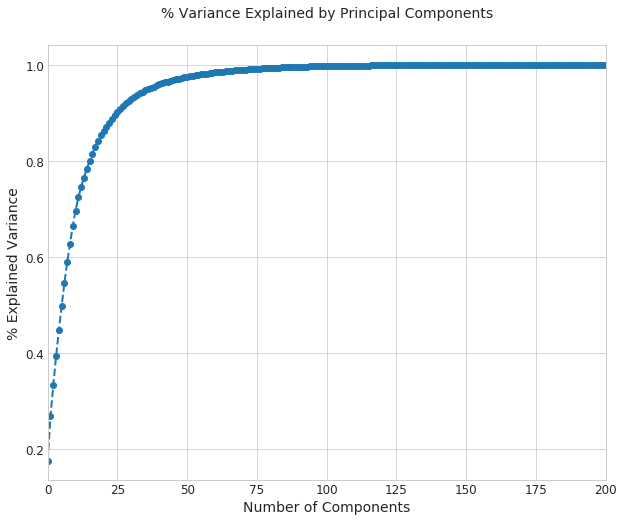

In [58]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [60]:
pca=PCA(n_components=20,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 20 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 20 components is: 0.853512946069


In [61]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [62]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,20).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.94093593821
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31123   769    31892
True        1441  4084     5525
__all__    32564  4853    37417

Accuracy of the model for test data is: 0.934894162925
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7759   226     7985
True         383   986     1369
__all__     8142  1212     9354



Logistic Regression
Accuracy of the model for training data is: 0.934174305797
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31280   612    31892
True        1851  3674     5525
__all__    33131  4286    37417

Accuracy of the model for test data is: 0.932328415651
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7829   156     7985
True         477   892     1369
__all__     8306  1048     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.947189780047
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31177   715    31892
True        1261  4264     5525
__all__    32438  4979    37417

Accuracy of the model for test data is: 0.939918751336
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7771   214     7985
True         348  1021     1369
__all__     8119  1235     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.938771146805
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31031   861    31892
True        1430  4095     5525
__all__    32461  4956    37417

Accuracy of the model for test data is: 0.934573444516
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7750   235     7985
True         377   992     1369
__all__     8127  1227     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.943154181255
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31107   785    31892
True        1342  4183     5525
__all__    32449  4968    37417

Accuracy of the model for test data is: 0.938742783836
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7773   212     7985
True         361  1008     1369
__all__     8134  1220     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.947430312425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31200   692    31892
True        1275  4250     5525
__all__    32475  4942    37417

Accuracy of the model for test data is: 0.938742783836
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7771   214     7985
True         359  1010     1369
__all__     8130  1224     9354



Bagging Classifier
Accuracy of the model for training data is: 0.947029425128
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31214   678    31892
True        1304  4221     5525
__all__    32518  4899    37417

Accuracy of the model for test data is: 0.9398118452
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7784   201     7985
True         362  1007     1369
__all__     8146  1208     9354



Neural Network-1
The accuracy of the model on training data is: 0.943100729616


Predicted  False  True  __all__
Actual                         
False      31103   789    31892
True        1340  4185     5525
__all__    32443  4974    37417

The accuracy of the model on test data is: 0.939491126791


Predicted  False  True  __all__
Actual                         
False       7774   211     7985
True         355  1014     1369
__all__     8129  1225     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [63]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [64]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.940936,4084.0,31123.0,769.0,1441.0,0.024113,0.260814
LogisticRegression,0.934174,3674.0,31280.0,612.0,1851.0,0.019190,0.335023
RandomForestClassifier,0.947190,4264.0,31177.0,715.0,1261.0,0.022419,0.228235
AdaBoostClassifier,0.938771,4095.0,31031.0,861.0,1430.0,0.026997,0.258824
GradientBoostingClassifier,0.943154,4183.0,31107.0,785.0,1342.0,0.024614,0.242896
ExtraTreeClassifier,0.947430,4250.0,31200.0,692.0,1275.0,0.021698,0.230769
BaggingClassifier,0.947029,4221.0,31214.0,678.0,1304.0,0.021259,0.236018
Neural Network-1,0.943101,4185.0,31103.0,789.0,1340.0,0.024740,0.242534


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.934894,986.0,7759.0,226.0,383.0,0.028303,0.279766,0.845965,0.728257
LogisticRegression,0.932328,892.0,7829.0,156.0,477.0,0.019537,0.348430,0.816017,0.708277
RandomForestClassifier,0.939919,1021.0,7771.0,214.0,348.0,0.026800,0.254200,0.859500,0.750729
AdaBoostClassifier,0.934573,992.0,7750.0,235.0,377.0,0.029430,0.275383,0.847593,0.727869
GradientBoostingClassifier,0.938743,1008.0,7773.0,212.0,361.0,0.026550,0.263696,0.854877,0.744929
ExtraTreeClassifier,0.938743,1010.0,7771.0,214.0,359.0,0.026800,0.262235,0.855482,0.745163
BaggingClassifier,0.939812,1007.0,7784.0,201.0,362.0,0.025172,0.264427,0.855201,0.748751
Neural Network-1,0.939491,1014.0,7774.0,211.0,355.0,0.026425,0.259313,0.855201,0.748359


In [65]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')